In [47]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [48]:
# Read the dataset
df = pd.read_csv('../Dataset/ACB-Historical-Data_Group-9.csv',index_col='Date', parse_dates=True)
df.dropna() #Drop missing value
df = df.sort_values(by='Date', ascending=True)
df =df.reset_index(drop=True) #Reset the index
print(df)

          Price       Open       High        Low    Vol. Change %
0     11,361.00  11,285.20  11,398.80  11,171.60   3.91M    1.01%
1     11,512.40  11,361.00  11,550.30  11,323.10   8.24M    1.33%
2     11,474.60  11,512.40  11,626.00  11,398.80   6.51M   -0.33%
3     11,474.60  11,436.70  11,512.40  11,361.00   3.11M    0.00%
4     11,550.30  11,512.40  11,626.00  11,474.60   8.72M    0.66%
...         ...        ...        ...        ...     ...      ...
1303  29,450.00  29,500.00  29,850.00  29,250.00   7.54M    0.68%
1304  29,650.00  29,700.00  29,700.00  29,300.00  10.69M    0.68%
1305  29,250.00  29,700.00  29,750.00  29,250.00  13.45M   -1.35%
1306  25,565.20  25,347.80  25,565.20  25,087.00  15.08M  -12.60%
1307  24,650.00  25,000.00  25,300.00  24,650.00  11.12M   -3.58%

[1308 rows x 6 columns]


In [49]:
print(df.dtypes)

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [50]:
# Hàm chuyển đổi
def convert_str_to_number(str):
    return float(str.replace(',', ''))

def convert_change_to_number(change_str):
    return float(change_str.strip('%')) / 100

def convert_volume_to_number(volume_str):
    factor = {'K': 1000, 'M': 1000000, 'B': 1000000000}
    return int(float(volume_str[:-1]) * factor[volume_str[-1]]) if volume_str[-1] in factor else int(volume_str)

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'], df['Open'], df['High'], df['Low'] = [df[col].apply(convert_str_to_number) for col in ['Price', 'Open', 'High', 'Low']]
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

print(df)
df.describe()

        Price     Open     High      Low      Vol.  Change %
0     11361.0  11285.2  11398.8  11171.6   3910000    0.0101
1     11512.4  11361.0  11550.3  11323.1   8240000    0.0133
2     11474.6  11512.4  11626.0  11398.8   6510000   -0.0033
3     11474.6  11436.7  11512.4  11361.0   3110000    0.0000
4     11550.3  11512.4  11626.0  11474.6   8720000    0.0066
...       ...      ...      ...      ...       ...       ...
1303  29450.0  29500.0  29850.0  29250.0   7540000    0.0068
1304  29650.0  29700.0  29700.0  29300.0  10690000    0.0068
1305  29250.0  29700.0  29750.0  29250.0  13450000   -0.0135
1306  25565.2  25347.8  25565.2  25087.0  15080000   -0.1260
1307  24650.0  25000.0  25300.0  24650.0  11120000   -0.0358

[1308 rows x 6 columns]


,Price,Open,High,Low,Vol.,Change %
count,1308.000000,1308.000000,1308.000000,1308.000000,1.308000e+03,1308.000000
mean,19251.080122,19252.003287,19477.664526,19027.109098,7.817892e+06,0.000792
std,5987.083276,5994.933392,6038.280436,5938.080094,6.166880e+06,0.019501
min,8763.100000,7926.200000,9255.400000,7926.200000,7.420600e+05,-0.175200
25%,12075.875000,12110.800000,12258.375000,11914.000000,3.487500e+06,-0.008000
50%,20466.000000,20466.000000,20674.000000,20219.500000,6.005000e+06,0.000000
75%,24412.000000,24056.000000,24568.000000,23891.500000,1.023500e+07,0.009100
max,30360.000000,30400.000000,30560.000000,29300.000000,4.873000e+07,0.096100


In [51]:
df1=df.reset_index()['Price']
df1

0       11361.0
1       11512.4
2       11474.6
3       11474.6
4       11550.3
         ...   
1303    29450.0
1304    29650.0
1305    29250.0
1306    25565.2
1307    24650.0
Name: Price, Length: 1308, dtype: float64

In [52]:
# 3. Split into train and test sets
train_size = int(0.9 * len(df))
test_size = len(df)-train_size

train_data = df[:train_size]
test_data = df[train_size:]
train_data

,Price,Open,High,Low,Vol.,Change %
0,11361.0,11285.2,11398.8,11171.6,3910000,0.0101
1,11512.4,11361.0,11550.3,11323.1,8240000,0.0133
2,11474.6,11512.4,11626.0,11398.8,6510000,-0.0033
3,11474.6,11436.7,11512.4,11361.0,3110000,0.0000
4,11550.3,11512.4,11626.0,11474.6,8720000,0.0066
...,...,...,...,...,...,...
1172,22400.0,22400.0,22600.0,22250.0,5050000,-0.0067
1173,22450.0,22450.0,22600.0,22200.0,3420000,0.0022
1174,22700.0,22450.0,22900.0,22450.0,10300000,0.0111
1175,23250.0,23000.0,23500.0,22950.0,32330000,0.0242


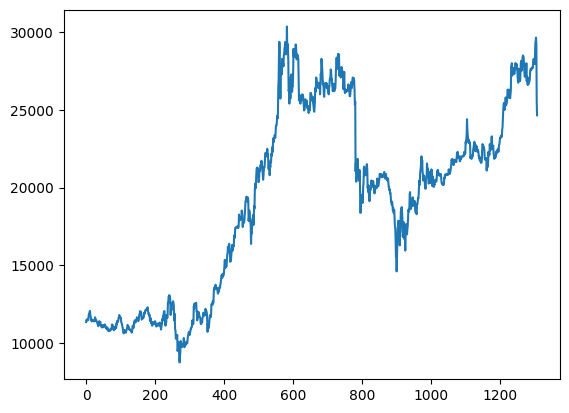

In [53]:
plt.plot(df1)

In [54]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [55]:
# df1.shape
print(df1)

[[0.12029041]
 [0.12730068]
 [0.12555043]
 ...
 [0.94860373]
 [0.77798666]
 [0.7356102 ]]


In [56]:
# 4. split the data into train and test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [57]:
#Training process
# a. convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# b. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [58]:
print(X_train)

[[0.12029041 0.12730068 0.12555043 ... 0.13782534 0.13431557 0.13256069]
 [0.12730068 0.12555043 0.12555043 ... 0.13431557 0.13256069 0.13449152]
 [0.12555043 0.12555043 0.12905556 ... 0.13256069 0.13449152 0.12765258]
 ...
 [0.59670138 0.60827711 0.62448314 ... 0.64994976 0.63837403 0.63142858]
 [0.60827711 0.62448314 0.622168   ... 0.63837403 0.63142858 0.63374373]
 [0.62448314 0.622168   0.62679829 ... 0.63142858 0.63374373 0.64531947]]


In [59]:
# 8. Define GRU Model
model = xgb.XGBRegressor(
             colsample_bynode=1, colsample_bytree=1, gamma=0.01,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42)

In [60]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=1, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.01, grow_policy=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=0, max_depth=8,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=1, nthread=None, num_parallel_tree=None, ...)

In [61]:
# 7. Dự báo dữ liệu test, val
y_pred=model.predict(X_test)
y_pred

array([0.8718893 , 0.82917434, 0.85427356, 0.82475644, 0.82475644,
       0.82917434, 0.82475644, 0.8426422 , 0.82917434, 0.82917434,
       0.8426422 , 0.85427356, 0.85427356, 0.8585512 , 0.85427356,
       0.85427356, 0.8585512 , 0.8585512 , 0.8585512 , 0.8585512 ,
       0.8718893 , 0.8718893 , 0.8718893 , 0.8718893 , 0.8718893 ,
       0.8973921 , 0.8973921 , 0.8973921 , 0.8973921 , 0.8973921 ],
      dtype=float32)

In [62]:
# 12. inverse transform the scaled ytest data back to its original scale.
y_pred_ = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_ = scaler.inverse_transform(y_test.reshape(-1,1))
# 12. Đánh giá độ chính xác thuật toán 
test_rmse = np.sqrt(np.mean((y_pred_ - y_test_)**2))
print('Testing RMSE:', test_rmse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test_, y_pred_)
print('Testing MAE:', test_mae)

from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test_, y_pred_)
print('Testing MAPE:', test_mape)  

Testing RMSE: 797.5681848271603
Testing MAE: 616.6266015625001
Testing MAPE: 0.022187612339840602


In [63]:
#Dự đoán 30 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 30
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.7318804]
2 day output [0.7318804]
3 day output [0.7318804]
4 day output [0.7394174]
5 day output [0.7394174]
6 day output [0.7466487]
7 day output [0.75985175]
8 day output [0.75985175]
9 day output [0.75985175]
10 day output [0.75985175]
11 day output [0.75985175]
12 day output [0.75985175]
13 day output [0.75985175]
14 day output [0.75985175]
15 day output [0.75985175]
16 day output [0.75985175]
17 day output [0.75985175]
18 day output [0.75985175]
19 day output [0.75985175]
20 day output [0.75985175]
21 day output [0.75985175]
22 day output [0.75985175]
23 day output [0.75309354]
24 day output [0.75309354]
25 day output [0.75309354]
26 day output [0.75985175]
27 day output [0.75985175]
28 day output [0.75309354]
29 day output [0.75985175]
Output of predicted next days:  [0.7364177703857422, 0.7318804264068604, 0.7318804264068604, 0.7318804264068604, 0.7394173741340637, 0.7394173741340637, 0.7466487288475037, 0.7598517537117004, 0.7598517537117004, 0.7598517537117004,

In [64]:
y_pred = y_pred.reshape(-1,1)
y_pred = scaler.inverse_transform(y_pred)

print("Test data prediction:", y_pred.shape)

Test data prediction: (30, 1)


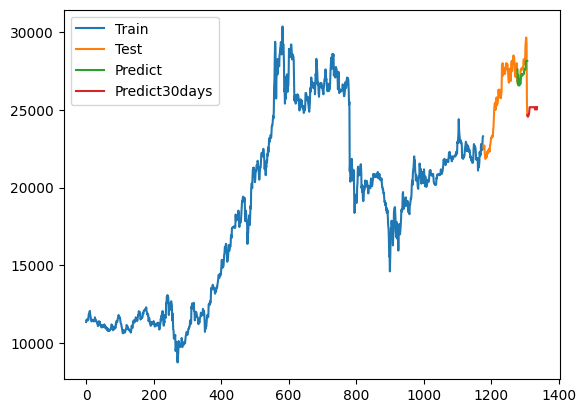

In [65]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(np.array(lst_output).reshape(-1,1))), step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [66]:
#Dự đoán 60 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 60
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.7318804]
2 day output [0.7318804]
3 day output [0.7318804]
4 day output [0.7394174]
5 day output [0.7394174]
6 day output [0.7466487]
7 day output [0.75985175]
8 day output [0.75985175]
9 day output [0.75985175]
10 day output [0.75985175]
11 day output [0.75985175]
12 day output [0.75985175]
13 day output [0.75985175]
14 day output [0.75985175]
15 day output [0.75985175]
16 day output [0.75985175]
17 day output [0.75985175]
18 day output [0.75985175]
19 day output [0.75985175]
20 day output [0.75985175]
21 day output [0.75985175]
22 day output [0.75985175]
23 day output [0.75309354]
24 day output [0.75309354]
25 day output [0.75309354]
26 day output [0.75985175]
27 day output [0.75985175]
28 day output [0.75309354]
29 day output [0.75985175]
30 day output [0.75309354]
31 day output [0.75309354]
32 day output [0.75985175]
33 day output [0.75985175]
34 day output [0.75985175]
35 day output [0.75309354]
36 day output [0.75309354]
37 day output [0.75309354]
38 day output [0

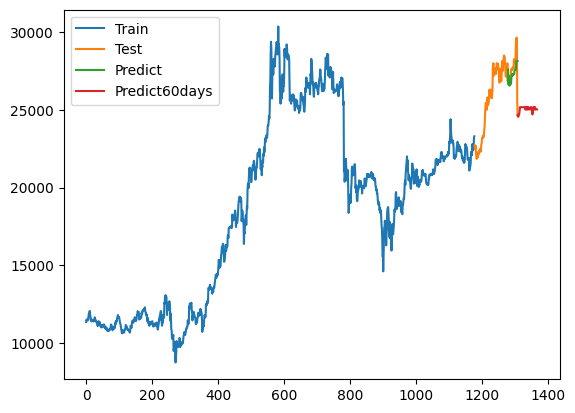

In [67]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(np.array(lst_output).reshape(-1,1))), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))

plt.legend(['Train', 'Test', 'Predict', 'Predict60days'])
plt.show()

In [68]:
#Dự đoán 90 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 90
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.7318804]
2 day output [0.7318804]
3 day output [0.7318804]
4 day output [0.7394174]
5 day output [0.7394174]
6 day output [0.7466487]
7 day output [0.75985175]
8 day output [0.75985175]
9 day output [0.75985175]
10 day output [0.75985175]
11 day output [0.75985175]
12 day output [0.75985175]
13 day output [0.75985175]
14 day output [0.75985175]
15 day output [0.75985175]
16 day output [0.75985175]
17 day output [0.75985175]
18 day output [0.75985175]
19 day output [0.75985175]
20 day output [0.75985175]
21 day output [0.75985175]
22 day output [0.75985175]
23 day output [0.75309354]
24 day output [0.75309354]
25 day output [0.75309354]
26 day output [0.75985175]
27 day output [0.75985175]
28 day output [0.75309354]
29 day output [0.75985175]
30 day output [0.75309354]
31 day output [0.75309354]
32 day output [0.75985175]
33 day output [0.75985175]
34 day output [0.75985175]
35 day output [0.75309354]
36 day output [0.75309354]
37 day output [0.75309354]
38 day output [0

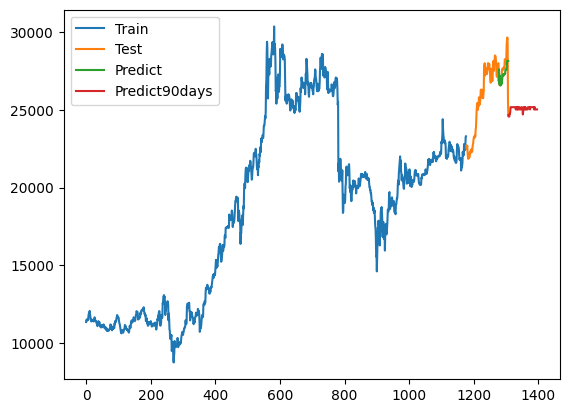

In [69]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(np.array(lst_output).reshape(-1,1))), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))

plt.legend(['Train', 'Test', 'Predict', 'Predict90days'])
plt.show()